<a href="https://colab.research.google.com/github/srilav/neuralnetwork/blob/main/Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification 

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:

 

*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below. 

![img](http://www.nada.kth.se/cvap/actions/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:** 

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN; 
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file; 
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability; 
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required packages

In [ ]:
import keras
from keras.models import load_model
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam

In [ ]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from keras.preprocessing import image
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image
import re
import os
import random
import shutil
import keras

seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

A video consists of an ordered sequence of frames. Each frame contains spatial information, and the sequence of those frames contains temporal information. To model both of these aspects, we use a hybrid architecture that consists of convolutions (for spatial processing) as well as recurrent layers (for temporal processing). Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) consisting of GRU layers. This kind of hybrid architecture is popularly known as a CNN-RNN.

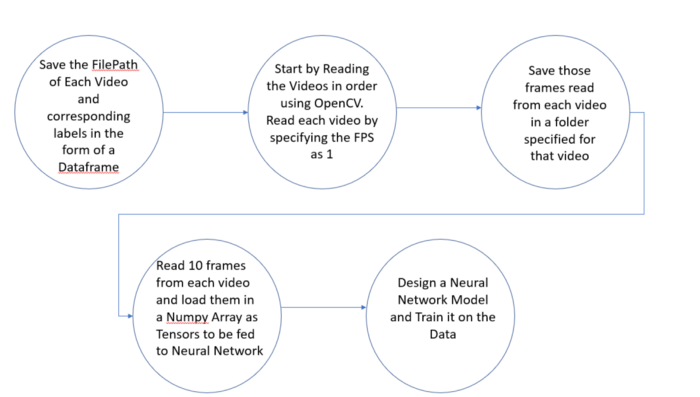

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [ ]:
# TensorFlow 
import tensorflow as tf
# Some modules to help with reading the UCF101 dataset.
import random
import os
import cv2
import numpy as np
import pandas as pd

# Some modules to display an animation using imageio.
import imageio
from IPython import display

In [ ]:
train_data_path = "/content/Actions/train/"
test_data_path = "/content/Actions/test/"

In [ ]:
classes_names = os.listdir(train_data_path)
classes_names

['boxing', 'jogging', 'handwaving', 'Walking', 'running', 'Handclapping']

In [ ]:
data_dir_list = os.listdir(train_data_path)
num_classes = 6
labels_name={'Walking':0, 'boxing':1, 'handwaving':2, 'Handclapping':3, 'running':4, 'jogging':5}

In [ ]:
labels_name['Walking']

0

To determine the number of frames in a video file via the API by provided by OpenCV, we need to utilize what are called capture properties, or what OpenCV calls CAP_PROP.deally, passing the respective property name into the .get method of the video pointer will allow us to obtain the total number of frames in the video 

In [ ]:
#dimension of each frame of videos
img_height , img_width = 120, 120
#considering only 70 frames per video
seq_len = 50 #number of images we pass as one sequence

# Extraction of frames from videos

In [ ]:
def get_video_frames(self,video_path):
  frames_list = []
  vidObj = cv2.VideoCapture(video_path)
  total_frames = vidObj.get(cv2.CAP_PROP_FRAME_COUNT)
  if total_frames>2*self.frames_per_video:
    start = np.random.randint(0,total_frames-2*self.frames_per_video)
    frame_ids = range(start,start+2*self.frames_per_video,2)
  else:
    vidObj.release()
    cv2.destroyAllWindows()
    return None
  out=[]
  for frame_id in frame_ids:
    vidObj.set(cv2.CAP_PROP_POS_FRAMES,frame_id)
    success, image = vidObj.read()
    out.append(image)
  vidObj.release()
  cv2.destroyAllWindows()
  return out

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
#  Creating frames from videos
def frames_extraction(video_path):
    """Creates frames for a video specified in the path given """
    frames_list = []    
    #creating an object by capturing the video given.
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable
    #The count variable ensures that the number of extracted frames should be equal to the seq_len 
    count = 1
    while count <= seq_len:  
        #reading one frame at a time,, it returns status (success) and the actual frame (image)     
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            image  = crop_center_square(image )
            # Converting the BGR Frame to RGB Frame
            rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames_list.append(rgb_frame)
            count += 1
        else:
            print("Defected frame")
            break
    # When everything done, release the video capture object
    vidObj.release()
    # Closes all the frame
    cv2.destroyAllWindows()        
    return frames_list

actual data from the sequence of images

In [ ]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
           frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
           if len(frames) == seq_len:
                X.append(frames)            
                y = [0]*len(classes_names)
                y[classes_names.index(c)] = 1
                Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X,Y

In [ ]:
X_train, y_train = create_data(train_data_path)

boxing
jogging
handwaving
Walking
running
Handclapping


In [ ]:
X_train.shape,y_train.shape

((479, 50, 120, 120, 3), (479, 6))

In [ ]:
X_test, y_test = create_data(test_data_path)

boxing
jogging
handwaving
Walking
running
Handclapping


In [ ]:
X_test.shape,y_test.shape

((120, 50, 120, 120, 3), (120, 6))

#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

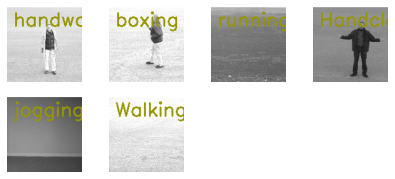

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Create a Matplotlib figure
plt.figure(figsize = (7, 8))
# Get Names of all classes in UCF50
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(classes_names)), 6)
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
    # Getting Class Name using Random Index
    selected_class_Name = classes_names[random_index]
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'/content/Actions/train/{selected_class_Name}')
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'/content/Actions/train/{selected_class_Name}/{selected_video_file_name}')
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()
    bgr_frame = crop_center_square(bgr_frame)
    # Converting the BGR Frame to RGB Frame
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (150, 150, 3), 2)
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

understanding the input size of the model:
Keras provides ConvLSTM2D for ConvLSTM,it takes 5D tensor as the input and based on the channel argument position there are two ways to provide inputs.
1 sample consist of sequence of 70 images (equal to the seq_len) and each image is 120×120 (img_height, img_width) and 3 channel (RGB)

In [ ]:
NUM_FEATURES = 1440

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((seq_len, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = Adam(learning_rate=0.0001)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(6, activation = "softmax"))

ConvLSTM based model design
In the ConvLSTM2D we are giving inputs of shape (70, 160, 120, 3) and the entire set of samples will be divided based on input shape.setting return_sequnce=False, because of this ConvLSTM will give output only after the last timestamp and not for every timestamp

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 118, 118, 64)      154624    
                                                                 
 dropout (Dropout)           (None, 118, 118, 64)      0         
                                                                 
 flatten (Flatten)           (None, 891136)            0         
                                                                 
 dense (Dense)               (None, 512)               456262144 
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1

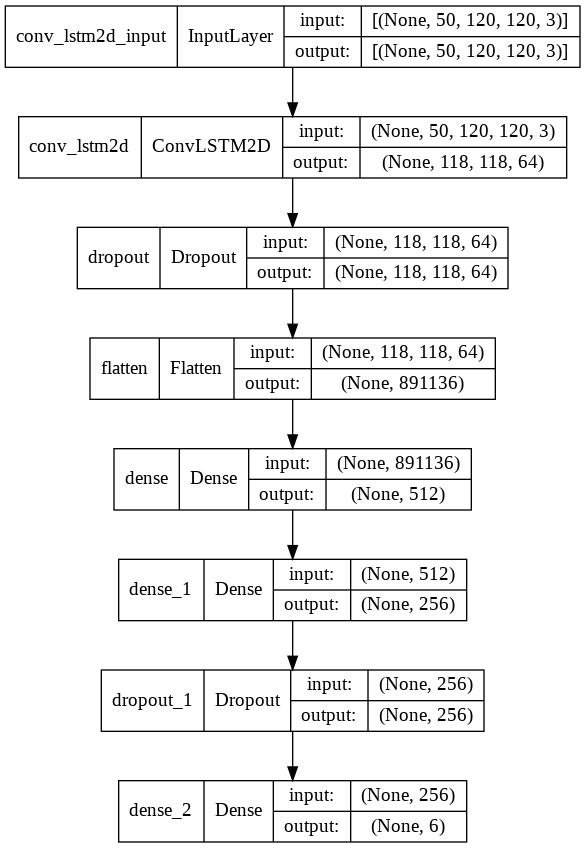

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='cnn_lstm.png',show_shapes=True)
from IPython.display import Image
Image("cnn_lstm.png")

#### Setup the parameters and train the model with epochs, batch wise 

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
 
history = model.fit(x = X_train, y = y_train, epochs=40, batch_size = 5 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Epoch 1/40


ResourceExhaustedError: ignored

In [ ]:
# Note: There will be a high memory requirement for the training steps below. 
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE

### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.optimizers import Nadam

In [ ]:
frames=70
channels=3
rows=120
columns=120
classes= 6


video = Input(shape=(frames,
                     rows,
                     columns, channels))
cnn_base = VGG16(input_shape=(rows,columns,channels),weights=None,include_top=False)

cnn_out = GlobalAveragePooling2D()(cnn_base.output)
print(cnn_base.summary())
print("----------------------------------")
cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
cnn.trainable =False
print(cnn.summary())
print("----------------------------------")

encoded_frames = TimeDistributed(cnn)(video)
print(encoded_frames)
encoded_sequence = LSTM(256)(encoded_frames)
# Create the dropout layers
dropout1 = Dropout(0.2)(encoded_sequence)
#flatten=Flatten()
hidden_layer = Dense(units=1024, activation="relu")(dropout1)
dropout2 = Dropout(0.3)(hidden_layer)
hidden_layer1 = Dense(units=512, activation="relu")(dropout2)
hidden_layer2 = Dense(units=256, activation="relu")(hidden_layer1)
hidden_layer3 = Dense(units=6, activation="relu")(hidden_layer2)
outputs = Dense(units=classes, activation="softmax")(hidden_layer2)
model = Model([video], outputs)
model.summary()

optimizer = Nadam(learning_rate=0.002,beta_1=0.9,beta_2=0.999,epsilon=1e-08,schedule_decay=0.004)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"]) 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

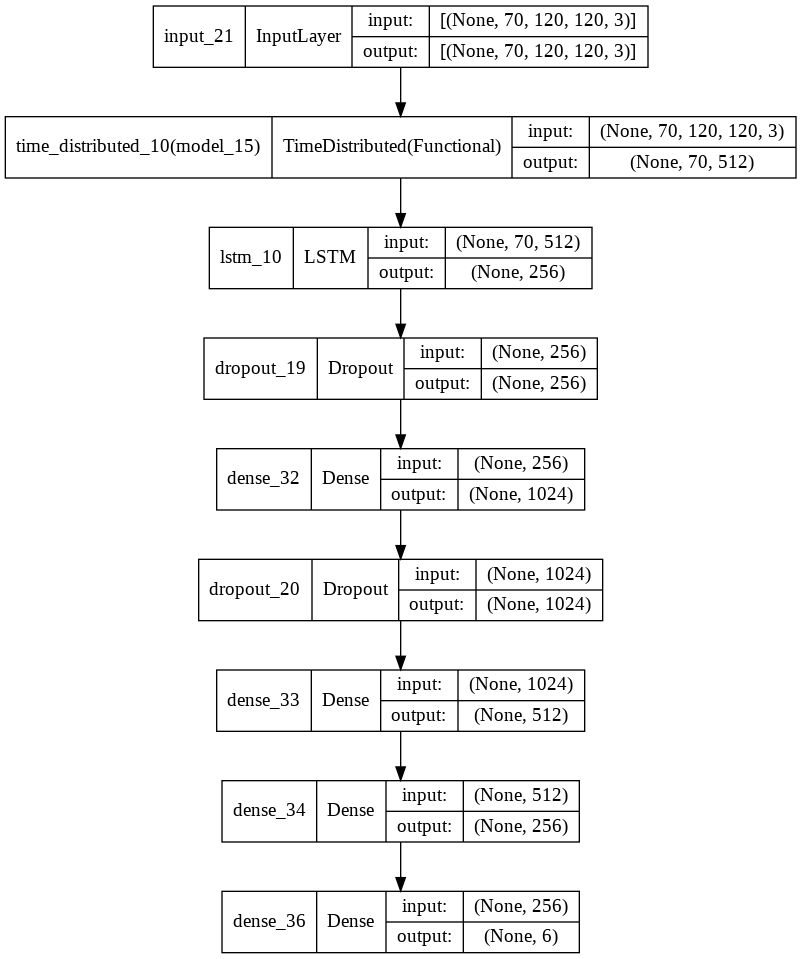

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='vgg.png',show_shapes=True)
from IPython.display import Image
Image("vgg.png")

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
 
history = model.fit(x = X_train, y = y_train, epochs=40, batch_size = 8 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Epoch 1/40
48/48 [==============================] - 133s 3s/step - loss: 1.7761 - accuracy: 0.2219 - val_loss: 1.8917 - val_accuracy: 0.0000e+00
Epoch 2/40
48/48 [==============================] - 89s 2s/step - loss: 1.7664 - accuracy: 0.1958 - val_loss: 1.9607 - val_accuracy: 0.0000e+00
Epoch 3/40
48/48 [==============================] - 88s 2s/step - loss: 1.7470 - accuracy: 0.2141 - val_loss: 2.0262 - val_accuracy: 0.0000e+00
Epoch 4/40
48/48 [==============================] - 88s 2s/step - loss: 1.7421 - accuracy: 0.1958 - val_loss: 2.0928 - val_accuracy: 0.0000e+00
Epoch 5/40
48/48 [==============================] - 89s 2s/step - loss: 1.7288 - accuracy: 0.2089 - val_loss: 2.1566 - val_accuracy: 0.0000e+00
Epoch 6/40
48/48 [==============================] - 88s 2s/step - loss: 1.7216 - accuracy: 0.2115 - val_loss: 2.2219 - val_accuracy: 0.0000e+00
Epoch 7/40
48/48 [==============================] - 89s 2s/step - loss: 1.7143 - accuracy: 0.2141 - val_loss: 2.2857 - val_accuracy: 0.

In [ ]:
 earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
history = model.fit(x = X_train, y = y_train, epochs=40, batch_size = 8 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Epoch 1/40


InvalidArgumentError: ignored

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# YOUR CODE HERE

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification